<a href="https://colab.research.google.com/github/cfong32/netflix-prize/blob/main/step3_gradient_descent_M50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# download preprocessed dataset
!wget -qO ratings_M50-MF10.dfpkl https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/ERH77foX8FJHmpPoczPf4-UBxHLwVZh-qobnU9uQvGuguw?download=1
!wget -qO ratings_M500-MF10.dfpkl https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/EY94E7t0oQ9Hs5ChnFwFVMQB6PqKrwdvejzDkteFooAbSg?download=1

In [2]:
import torch
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
pd.set_option('display.min_rows', 4)

In [3]:
# read dataset into dataframe

df = (pd.read_pickle('ratings_M50-MF10.dfpkl')
      .assign(target=lambda x: x.rating/6)
)
N = df.user.nunique()
M = df.movie.nunique()

print('num_user:', N, 'num_movie:', M)
display(df)

num_user: 111 num_movie: 50


,user,movie,rating,target
0,0,0,4.0,0.666667
1,0,7,5.0,0.833333
...,...,...,...,...
1616,110,44,4.0,0.666667
1617,110,46,3.0,0.500000


In [4]:
# split data into train and test sets

split = 0.8
train = df.sample(frac=split)
test  = df[~df.index.isin(train.index)]

display(train)
display(test)

,user,movie,rating,target
630,35,15,3.0,0.500000
1207,75,25,3.0,0.500000
...,...,...,...,...
376,23,23,1.0,0.166667
848,48,30,1.0,0.166667


,user,movie,rating,target
1,0,7,5.0,0.833333
19,1,36,3.0,0.500000
...,...,...,...,...
1603,109,31,5.0,0.833333
1607,109,45,5.0,0.833333


In [5]:
# build the matrix-multiplication-based model

class UV(nn.Module):
    def __init__(self, N, M, D):                # N: num_user, M: num_movie, D: embedding dimension
        super().__init__()
        self.U = nn.Embedding(N, D)             # matrix U, user embeddings, sized N-by-D
        self.V = nn.Embedding(M, D)             # matrix V, movie embeddings, sized M-by-D
        
    def forward(self, u_idx, m_idx):
        U = self.U(u_idx)                       # retrieve user embeddings by user indexes
        V = self.V(m_idx)                       # retrieve movie embeddings by movie indexes
        dot_products = (U*V).sum(dim=1)         # predicted ratings are their dot products
        output = torch.sigmoid(dot_products)    # map to [0,1]
        return output

In [6]:
###
# training
###

# check GPU
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# set hyperparameters
D = 10              # embedding dimension
lr = 1e-3           # learning rate
batch_size = 1_000
max_epoch = 10_000
patience = 10       # early stop if not improving in this num of evaluations

# initialize model and ...
model = UV(N, M, D).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# convert data to torch Tensor
train_u_idx = torch.IntTensor  (train.user.values).to(device)
train_v_idx = torch.IntTensor  (train.movie.values).to(device)
train_y     = torch.FloatTensor(train.target.values).to(device)
train_size  = len(train_u_idx)

test_u_idx  = torch.IntTensor  (test.user.values).to(device)
test_v_idx  = torch.IntTensor  (test.movie.values).to(device)
test_y      = torch.FloatTensor(test.target.values).to(device)

# train
recs = []
min_test_loss = None
for epoch in range(max_epoch):

    # gradient descent
    model.train()
    optimizer.zero_grad()

    batch_idx = torch.randperm(train_size)[:batch_size]
    train_y_hat = model(train_u_idx[batch_idx], train_v_idx[batch_idx])
    loss = loss_fn(train_y_hat, train_y[batch_idx])
    loss.backward()
    optimizer.step()

    # evaluate test loss
    if epoch % 100 == 0:
        model.eval()
        test_y_hat = model(test_u_idx, test_v_idx)
        test_loss = loss_fn(test_y_hat, test_y).item()
        rec = {
            'epoch'     : epoch,
            'train_loss': loss.item(),
            'test_loss' : test_loss,
        }
        recs.append(rec)
        print(rec)

        # check for early stopping
        if min_test_loss is None or test_loss < min_test_loss:
            min_test_loss = test_loss
            not_improving_count = 0
        else:
            not_improving_count += 1
            if not_improving_count >= patience:
                break

{'epoch': 0, 'train_loss': 0.18575915694236755, 'test_loss': 0.21917492151260376}
{'epoch': 100, 'train_loss': 0.16200321912765503, 'test_loss': 0.2126418650150299}
{'epoch': 200, 'train_loss': 0.14057010412216187, 'test_loss': 0.20573534071445465}
{'epoch': 300, 'train_loss': 0.12174297124147415, 'test_loss': 0.1985255628824234}
{'epoch': 400, 'train_loss': 0.10224002599716187, 'test_loss': 0.19015872478485107}
{'epoch': 500, 'train_loss': 0.08585549890995026, 'test_loss': 0.18182030320167542}
{'epoch': 600, 'train_loss': 0.06967088580131531, 'test_loss': 0.17428980767726898}
{'epoch': 700, 'train_loss': 0.061662036925554276, 'test_loss': 0.1667174994945526}
{'epoch': 800, 'train_loss': 0.0496571883559227, 'test_loss': 0.16056738793849945}
{'epoch': 900, 'train_loss': 0.04673803225159645, 'test_loss': 0.15612320601940155}
{'epoch': 1000, 'train_loss': 0.043615713715553284, 'test_loss': 0.15246742963790894}
{'epoch': 1100, 'train_loss': 0.03669077157974243, 'test_loss': 0.1489809304475

<Axes: xlabel='epoch'>

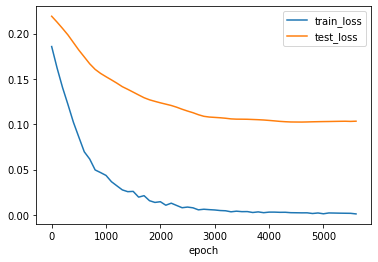

In [7]:
# training curves
pd.DataFrame(recs).set_index('epoch')[['train_loss', 'test_loss']].plot()

In [8]:
# resulted U and V
U = model.U.weight
V = model.V.weight

print('first few rows of,')
print('U:', U[:3])
print('V:', V[:3])

first few rows of,
U: tensor([[-0.5958,  0.0428, -0.5972,  0.2509, -1.0909, -0.1319,  0.0260, -0.8274,
         -0.9371, -0.9779],
        [-0.3265, -0.5641, -0.2102, -0.0090,  0.4743,  0.6286,  0.3211,  0.7240,
         -0.7716, -0.7676],
        [-2.8376,  1.4089,  0.0738, -0.3198, -1.1681, -0.9089, -0.2257, -0.6727,
         -0.0836, -0.8177]], device='cuda:0', grad_fn=<SliceBackward0>)
V: tensor([[ 0.4940,  0.7131, -0.5847, -0.2380,  0.1017, -0.3068, -0.9555,  0.1629,
         -1.9442,  0.9582],
        [ 0.6011,  0.6026, -0.4072, -0.1786,  0.7901,  0.4980, -0.8981,  0.0746,
         -0.5487,  0.4361],
        [ 0.6896, -0.4566,  0.6202,  0.9726,  1.4818, -1.1142, -0.2971,  0.8864,
          0.3397,  0.2374]], device='cuda:0', grad_fn=<SliceBackward0>)


In [9]:
# prediction results

test_y_hat = model(test_u_idx, test_v_idx).cpu().detach().numpy()

df_res = (
    test
    .assign(target_pred    =test_y_hat,
            rating_pred    =lambda x: (x.target_pred*6).clip(1,5),  # clipped between 1 and 5
            rating_residual=lambda x: x.rating - x.rating_pred)
)

df_res.sample(10)

,user,movie,rating,target,target_pred,rating_pred,rating_residual
551,29,43,2.0,0.333333,0.286146,1.716875,0.283125
1585,107,31,5.0,0.833333,0.566911,3.401469,1.598531
432,26,2,2.0,0.333333,0.371803,2.230818,-0.230818
1045,62,46,5.0,0.833333,0.383245,2.299469,2.700531
317,20,7,3.0,0.500000,0.034862,1.000000,2.000000
319,20,18,3.0,0.500000,0.225668,1.354009,1.645991
1265,80,31,5.0,0.833333,0.384129,2.304774,2.695226
1578,107,16,4.0,0.666667,0.599793,3.598760,0.401240
135,7,49,1.0,0.166667,0.160558,1.000000,0.000000
814,45,47,3.0,0.500000,0.560287,3.361722,-0.361722


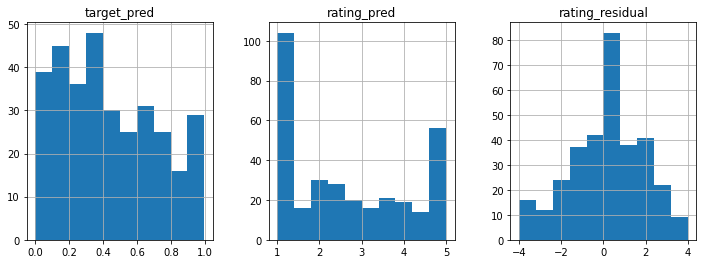

In [10]:
# distribution of residuals
df_res[['target_pred', 'rating_pred', 'rating_residual']].hist(figsize=(12,4), layout=(1,3))
plt.show()